# Deep Learning Final Project
### Predicting Respondents' Education Using 2021 General Social Survey Data 
Ramos, JD and Smith, D

In [1]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from keras import src
from keras.src.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from keras.src.models import Sequential
from keras.src.layers import LeakyReLU, Dense, Dropout, Flatten, Input
from keras.src.optimizers import Adam
import scipy.stats as stats

# Loading Data
## Numeric Representation of Data 
(For Numeric and Ordinal Variables)

In [2]:
# Initial data import
df_full = pd.read_csv('gss_2021_final.csv')
df = df_full.copy()  # Create a copy of the dataframe
df.head()  # Print check

,ID,BALLOT,WRKSTAT,HRS1,EVWORK,WRKSLF,OCC10,MARITAL,DIVORCE,SIBS,...,RELIGIMP,SPRTCONNCT,SPRTLRGR,SPRTPURP,GRTWRKS,FREEMIND,DECEVIDC,ADVFMSCI,BOARDREP,CONFEDVAC
0,1,3,1.0,36.0,NaN,2.0,5400.0,1.0,2.0,6.0,...,2.0,3.0,5.0,5.0,1.0,4.0,2.0,3.0,1.0,NaN
1,2,2,1.0,45.0,NaN,2.0,40.0,3.0,NaN,2.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,2.0,16.0,NaN,2.0,7750.0,5.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,2.0,27.0,NaN,1.0,4600.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,1,1.0,42.0,NaN,2.0,5840.0,5.0,NaN,4.0,...,3.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0,NaN,2.0


## Text Representation of Data
(For Categorical Variables)

In [3]:
# Import the same dataset represented as text (rather than numbers as above)
df_text = pd.read_csv('gss_as_text.csv')

# Print check
print(df_text.shape)
df_text.head()

(4032, 767)


C:\Users\doncs\AppData\Local\Temp\ipykernel_27828\2722354882.py:2: DtypeWarning: Columns (17,23,24,154,342,343,350,449,474) have mixed types. Specify dtype option on import or set low_memory=False.
  df_text = pd.read_csv('gss_as_text.csv')


,Unnamed: 0,YEAR,ID,WRKSTAT,HRS1,HRS2,EVWORK,WRKSLF,WRKGOVT,OCC10,...,RELITENNV,BIBLENV,POSTLIFENV,KIDSSOLNV,USCITZNNV,FUCITZNNV,FEPOLNV,SCIBNFTSV,ABANYG,FILEVERSION
0,0,2021,1,working full time,36.0,NaN,NaN,someone else,NaN,receptionists and information clerks,...,not very strong,inspired word,no,somewhat worse,NaN,NaN,NaN,about equal (phone mode only: volunteered),no,7222.31
1,1,2021,2,working full time,45.0,NaN,NaN,someone else,NaN,advertising and promotions managers,...,no religion,NaN,NaN,NaN,NaN,NaN,NaN,benefits greater,NaN,7222.31
2,2,2021,3,working part time,16.0,NaN,NaN,someone else,NaN,miscellaneous assemblers and fabricators,...,NaN,NaN,NaN,NaN,NaN,NaN,disagree,NaN,yes,7222.31
3,3,2021,4,working part time,27.0,NaN,NaN,self-employed,NaN,childcare workers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7222.31
4,4,2021,6,working full time,42.0,NaN,NaN,someone else,NaN,insurance claims and policy processing clerks,...,not very strong,inspired word,yes,NaN,a u.s. citizen,NaN,disagree,NaN,yes,7222.31


## Utilizing 'Helper' Text Files
These text files were built separately as feature-type lists.
They denote how we have classified each feature (either as categorical, ordinal, or numeric).

In [4]:
# Opening and processing .txt files
with open('cat_vars.txt', 'r') as f:
    cat_vars = [l.replace('\n','') for l in f.readlines()]

with open('ord_vars.txt', 'r') as f:
    ord_vars = [l.replace('\n', '') for l in f.readlines()]

with open('num_vars.txt', 'r') as f:
    num_vars = [l.replace('\n', '') for l in f.readlines()]

print(f'Total feature count: {len(num_vars) + len(cat_vars) + len(ord_vars)}')  # Print check

Total feature count: 181


# Remapping Overly-Complex Features
Some features had an unruly number of possible response categories, resulting in a sparse distribution of categories across samples. 

Here, we are remapping/combining some of these overly-complex categorical variables in order to keep the number of one-hot encoded features reasonable.

In [5]:
# Define remapping functions for relevant features
# Consult submitted feature codebook for full explanation of remapping decisions

# Remapping 'work status'
def remap_wrkstat(value):
    if pd.isnull(value):
        return value
    # Define current values
    old_vals = [
        value == 1,
        value == 2,
        value == 6,
        np.isin(value, [3, 4, 5, 7, 8])
    ]

    new_vals = [1, 2, 3, 4]  # Define new values

    return np.select(old_vals, new_vals, default=value)  # Return the remapping


# Remapping occupational codes
def remap_occ10(value):
    if pd.isnull(value):
        return value
    old_vals = [
        value in range(10, 431),
        value in range(500, 951),
        value in range(1000, 1241),
        value in range(1300, 1561),
        value in range(1600, 1961),
        value in range(2000, 2061),
        value in range(2100, 2161),
        value in range(2200, 2551),
        value in range(2600, 2961),
        value in range(3000, 3541),
        value in range(3600, 3651),
        value in range(3700, 3951),
        value in range(4000, 4161),
        value in range(4200, 4251),
        value in range(4300, 4651),
        value in range(4700, 4961),
        value in range(5000, 5941),
        value in range(6000, 6131),
        value in range(6200, 6941),
        value in range(7000, 7631),
        value in range(7700, 8961),
        value in range(9000, 9751)
    ]

    new_vals = list(range(1, 23))

    return np.select(old_vals, new_vals, default=value)


# Remapping marital status
def remap_marital(value):
    if pd.isnull(value):
        return value
    # Define current values
    old_vals = [
        value == 1,
        value == 2,
        np.isin(value, [3, 4]),
        value == 5
    ]

    new_vals = [1, 2, 3, 4]  # Define new values

    return np.select(old_vals, new_vals, default=value)  # Return the remapping


# Remapping region of interview
def remap_region(value):
    if pd.isnull(value):
        return value
    # Define current values
    old_vals = [
        value == 1,
        value == 2,
        np.isin(value, [3, 4]),
        value == 5,
        np.isin(value, [6, 7]),
        value == 8,
        value == 9,
    ]

    new_vals = [1, 2, 3, 4, 5, 6, 7]  # Define new values

    return np.select(old_vals, new_vals, default=value)  # Return the remapping


# Remapping religious preference
def remap_relig(value):
    if pd.isnull(value):
        return value
    # Define current values
    old_vals = [
        np.isin(value, [1, 2, 10, 11]),
        value == 3,
        value == 4,
        np.isin(value, [5, 12, 13]),
        np.isin(value, [6, 7, 8]),
        value == 9
    ]

    new_vals = [1, 2, 3, 4, 5, 6]  # Define new values

    return np.select(old_vals, new_vals, default=value)  # Return the remapping


# Remapping youth religious identity
def remap_relig16(value):
    if pd.isnull(value):
        return value
    # Define current values
    old_vals = [
        np.isin(value, [1, 2, 10, 11]),
        value == 3,
        value == 4,
        np.isin(value, [5, 12, 13]),
        np.isin(value, [6, 7, 8]),
        value == 9
    ]

    new_vals = [1, 2, 3, 4, 5, 6]  # Define new values

    return np.select(old_vals, new_vals, default=value)  # Return the remapping


# Remapping income classes
def remap_income16(value):
    if pd.isnull(value):
        return value
    # Define current values
    old_vals = [
        np.isin(value, [1, 2, 3, 4, 5, 6, 7, 8]),
        np.isin(value, [9, 10, 11, 12, 13, 14]),
        np.isin(value, [15, 16, 17, 18]),
        np.isin(value, [19, 20, 21]),
        np.isin(value, [22, 23, 24, 25, 26])
    ]

    new_vals = [1, 2, 3, 4, 5]  # Define new values

    return np.select(old_vals, new_vals, default=value)  # Return the remapping


# Define a dictionary mapping column names to the remapping functions
remap_functions = {
    'WRKSTAT': remap_wrkstat,
    'OCC10': remap_occ10,
    'MARITAL': remap_marital,
    'REGION': remap_region,
    'RELIG': remap_relig,
    'RELIG16': remap_relig16,
    'INCOME16': remap_income16
    }


def remap_features(df, remap_functions):
    """Applying remapping to relevant features."""
    for column, remap_func in remap_functions.items():  # For each k-v pair
        df[column] = df[column].apply(remap_func)  # Apply remapping function

    return df


# Call the remapping function to recode the variables in the DataFrame in-place
df = remap_features(df, remap_functions)

# Imputing NaN Values
This means-substitution process was only applied if a given respondent: 
1) Actually had the opportunity to respond to a given question (recall that there were three ballots), and
2) The column contains at most 10% nulls

In [6]:
def count_nulls(df, ballot_n, d_counts):
    """
    This function parses the rows as denoted by ballot type and counts the number of nulls per column.
    It computes the 'percent null' for a feature, determines whether the question was included on the relevant ballot type, and notes whether a given column contains 10% or fewer NaN values.
    """
    # Extract rows using a given ballot 'n' and count relevant nulls
    df_ballot_nulls = pd.DataFrame(df[df.BALLOT == ballot_n].isnull().sum(), columns=['n_nans'])

    # Compute 'percent null' metric
    df_ballot_nulls['percent_null'] = df_ballot_nulls.n_nans / d_counts[ballot_n] * 100

    # If *all* respondents at the ballot level failed to answer a question, we may assess that the question was not included on their ballot
    df_ballot_nulls['question_included_in_ballot'] = df_ballot_nulls.n_nans != d_counts[ballot_n]

    # Check if the 'percent null' metric is less than or equal to 10%
    df_ballot_nulls['percent_null_lte_10'] = df_ballot_nulls.percent_null <= 10

    return df_ballot_nulls  # Return computational dataframe

df_text_subset = df_text[df.columns]  # Extract the same columns present in our numeric dataset

val, cnt = np.unique(df_text.BALLOT, return_counts=True)  # Count the number of instances of each ballot type
d_counts = dict(zip(val, cnt))  # Store counts in dictionary

# Print check
print('Number of instances of each ballot type')
for k, v in d_counts.items():
    print(f'{k}: {v:<1}')

# Construct 'null frames' for each ballot
df_ballota_nulls = count_nulls(df_text_subset, 'ballot a', d_counts)
df_ballotb_nulls = count_nulls(df_text_subset, 'ballot b', d_counts)
df_ballotc_nulls = count_nulls(df_text_subset, 'ballot c', d_counts)

df_ballota_nulls  # Print check for one ballot

Number of instances of each ballot type
ballot a: 1360
ballot b: 1357
ballot c: 1315


,n_nans,percent_null,question_included_in_ballot,percent_null_lte_10
ID,0,0.000000,True,True
BALLOT,0,0.000000,True,True
WRKSTAT,4,0.294118,True,True
HRS1,630,46.323529,True,False
EVWORK,863,63.455882,True,False
...,...,...,...,...
FREEMIND,159,11.691176,True,False
DECEVIDC,157,11.544118,True,False
ADVFMSCI,160,11.764706,True,False
BOARDREP,1360,100.000000,False,False


In [7]:
# Now that we've computed nulls per ballot, we may perform imputation
def fillna_perballot(df, ballot_type, df_nulls, vars):
    """
    This function imputes means for columns that are 10% or less 'null by metric' on the ballot level.
    We fill missing values in-place with the column mean only if: 
    1. The participant had the opportunity to respond to that question
    2. At least 90% of relevant participants responded to that question.
    """
    cols = df_nulls.index.values  # Define columns
    cols_lte_10 = cols[df_nulls.percent_null_lte_10 == True]  # Define columns which are 10% or less 'null by metric'

    for col in cols_lte_10:  # For those columns
        if col in vars:  # If the column is numerical or ordinal
            mask = df['BALLOT'] == ballot_type   # Create a mask to locate rows for a given ballot
            mean = df[col].mean()  # Calculate column mean
            df.loc[mask, col] = df.loc[mask, col].fillna(mean)  # And fill NaN values with the column mean only for that ballot

df['BALLOT'] = df_text['BALLOT']  # Use the text-based dataset to set the value in the BALLOT column

df_impute = df.copy(deep=True)  # Create a deep copy for spot-checking

# Perform imputation at the ballot level
fillna_perballot(df_impute, 'ballot a', df_ballota_nulls, num_vars + ord_vars)
fillna_perballot(df_impute, 'ballot b', df_ballotb_nulls, num_vars + ord_vars)
fillna_perballot(df_impute, 'ballot c', df_ballotc_nulls, num_vars + ord_vars)

# Perform Imputation Spot Check

In [8]:
print('For PARSOL: (this question was asked on ballots b and c, but not a,\nand so we expect exactly 1360 nulls after imputation: this is the\nnumber of participants who recieved ballot a)')
print(f'\nn_nans before imputation: {df.PARSOL.isnull().sum()}')
print(f'n_nans after imputation: {df_impute.PARSOL.isnull().sum()}')

print('\n\nFor HAPPY: (this question was asked on all ballots, so we expect 0\nhere if most participants responded to this question)')
print(f'\nn_nans before imputation: {df.HAPPY.isnull().sum()}')
print(f'n_nans after imputation: {df_impute.HAPPY.isnull().sum()}')

df = df_impute  # The spot check was passed - we can update the main 'df' dataframe using our imputed data

For PARSOL: (this question was asked on ballots b and c, but not a,
and so we expect exactly 1360 nulls after imputation: this is the
number of participants who recieved ballot a)

n_nans before imputation: 1379
n_nans after imputation: 1360


For HAPPY: (this question was asked on all ballots, so we expect 0
here if most participants responded to this question)

n_nans before imputation: 18
n_nans after imputation: 0


# One-Hot Encoding Categorical Features

In [9]:
# Build a list of categorical features which were remapped earlier
remapped = [
    'WRKSTAT',
    'OCC10',
    'MARITAL',
    'REGION',
    'RELIG',
    'RELIG16',
    'INCOME16'
    ]

def onehot_encode(df, df_text, cat_vars, remapped):
    cat_vars_text = [col for col in cat_vars if not col in remapped]  # Build a list of categorical features which were *not* remapped earlier
    
    for col in cat_vars_text:  # Replace categorical features which were *not* remapped with column values from the text dataset
        df[col] = df_text[col]

    df_cat_vars = df[cat_vars]  # Extract categorical features
    
    encoder = OneHotEncoder(sparse_output=False)  # Instantiate one-hot encoder
    one_hot = encoder.fit_transform(df_cat_vars)  # Apply encoder to categorical feature dataframe

    # Push newly-encoded data into a dataframe
    df_encoded = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(df_cat_vars.columns))
    df_encoded.columns = [col.replace(' ', '_') for col in df_encoded.columns]
    
    df_dropped = df.drop(cat_vars, axis=1)  # Drop the original cat_var columns

    return pd.concat([df_dropped, df_encoded], axis=1)  # Concatenate the dataframes

df = onehot_encode(df, df_text, cat_vars, remapped)  # Apply function to main dataframe

df.head()  # Print check - encoded columns appear on the far right of the dataframe

,ID,BALLOT,HRS1,SIBS,CHILDS,AGE,EDUC,PAEDUC,MAEDUC,INCOM16,...,FAIRV_would_take_advantage_of_you,FAIRV_would_try_to_be_fair,FAIRV_nan,TRUSTV_can_trust,TRUSTV_can't_be_too_careful,TRUSTV_depends_(phone_mode_only:_volunteered),TRUSTV_nan,POSTLIFEV_no,POSTLIFEV_yes,POSTLIFEV_nan
0,1,ballot c,36.0,6.0,3.0,65.000000,12.0,9.0,14.0,2.00000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,ballot b,45.0,2.0,0.0,60.000000,16.0,16.0,16.0,5.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,ballot a,16.0,1.0,0.0,52.164639,NaN,17.0,16.0,2.73863,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,ballot b,27.0,2.0,2.0,52.164639,NaN,12.0,16.0,2.73863,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,6,ballot a,42.0,4.0,0.0,52.164639,14.0,NaN,14.0,3.00000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Scale Numerical & Ordinal Features

In [10]:
def scale_features(df, num_vars:list, ord_vars: list):
    scale_vars = num_vars + ord_vars  # Combine the num_vars and ord_vars lists into a single list for scaling
    
    scaler = MinMaxScaler()  # Instantiate a MinMax scaler (Note that MinMax scaler does not assume Gaussian distributions)

    df[scale_vars] = scaler.fit_transform(df[scale_vars])  # Fit the scaler to the specified columns

scale_features(df, num_vars, ord_vars)  # Run the scaling function on the dataframe

In [11]:
df.head()  # Print check

,ID,BALLOT,HRS1,SIBS,CHILDS,AGE,EDUC,PAEDUC,MAEDUC,INCOM16,...,FAIRV_would_take_advantage_of_you,FAIRV_would_try_to_be_fair,FAIRV_nan,TRUSTV_can_trust,TRUSTV_can't_be_too_careful,TRUSTV_depends_(phone_mode_only:_volunteered),TRUSTV_nan,POSTLIFEV_no,POSTLIFEV_yes,POSTLIFEV_nan
0,1,ballot c,0.404494,0.171429,0.375,0.661972,12.0,0.45,0.7,0.250000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,ballot b,0.505618,0.057143,0.000,0.591549,16.0,0.80,0.8,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,ballot a,0.179775,0.028571,0.000,0.481192,NaN,0.85,0.8,0.434658,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,ballot b,0.303371,0.057143,0.250,0.481192,NaN,0.60,0.8,0.434658,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,6,ballot a,0.471910,0.114286,0.000,0.481192,14.0,NaN,0.7,0.500000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Full Impute of Target Feature: EDUC

In [11]:
def impute_educ(df, column):
    """Impute missing values in the 'EDUC' column using means-substitution."""
    
    print(f"Number of missing values before imputation in column '{column}':", df[column].isnull().sum())  # Print number of missing values before imputation

    mean_value = df[column].mean()  # Define mean value
    df[column] = df[column].fillna(mean_value)  # Impute missing values using means-substitution

    print(f"Number of missing values after imputation in column '{column}':", df[column].isnull().sum())  # Print number of missing values after imputation


impute_educ(df, 'EDUC')  # Call imputation function for target feature' EDUC'

Number of missing values before imputation in column 'EDUC': 66
Number of missing values after imputation in column 'EDUC': 0


In [13]:
# Now that we've done all of this work, we write the cleaned, encoded, imputed, and scaled dataset to a .csv file for record keeping and easier future use.
df.to_csv('onehot_encoded_scaled_gss_2021.csv')

# Running Train Test Split

In [12]:
# Build list of columns to drop from feature set
feature_cols_to_drop = [
    'ID',  # Not relevant, just a row identifier
    'BALLOT',  # No longer relevant
    'EDUC',  # Target feature
    # The 'degree' features were all far too highly correlated with the 'EDUC' target feature, so we remove them all
    'DEGREE_associate/junior_college',
    "DEGREE_bachelor's",
    'DEGREE_graduate',
    'DEGREE_high_school',
    'DEGREE_less_than_high_school',
    'DEGREE_nan'
]

def make_datasets(df):
    feature_set = df.drop(feature_cols_to_drop, axis=1)  # Build feature set
    target_set = df['EDUC']  # Build target set

    # Run train/test split with 70/30 proportions
    feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.3, random_state=4)

    return feature_set, target_set, feature_train, feature_test, target_train, target_test


feature_set, target_set, X_train, X_test, y_train, y_test = make_datasets(df)

# Creating a 'Baseline' XGBoost Regressor

In [14]:
def xgb_regressor(X_train, y_train, X_test, y_test):
    """This function trains and evaluates an XGBoost regressor using its default settings."""

    # Instantiate a 'default' XGBoost regressor
    xgb = XGBRegressor(random_state=4)

    # Train the model on the training data
    xgb.fit(X_train, y_train)

    # Make predictions on the test data
    test_preds = xgb.predict(X_test)

    # Calculate R^2 for test data
    test_r2 = r2_score(y_test, test_preds)

    # Calculate RMSE for test data
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    return xgb, test_r2, test_rmse


xgb_model, test_r2, test_rmse = xgb_regressor(X_train, y_train, X_test, y_test)

print('Default XGBoost Regressor - Performance Metrics:')
print('Test Data:')
print(f'R^2: {test_r2:.4f}')
print(f'RMSE: {test_rmse:.4f}')

Default XGBoost Regressor - Performance Metrics:
Test Data:
R^2: 0.3383
RMSE: 2.2206


# Tuning the XGBoost Regressor

In [17]:
# Set seed value
np.random.seed(12345)

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'n_estimators':stats.randint(50, 200),
    'subsample': stats.uniform(0.5, 0.5),
    'reg_alpha': stats.uniform(0.1, 1),
    'reg_lambda': stats.uniform(0.1,1),
}

# Create the XGBoost model object
xgb_tuned_model = xgb.XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_tuned_model, param_distributions=param_dist, n_iter=1000, cv=5, scoring='neg_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best RMSE: ", np.sqrt(-1*random_search.best_score_))

# Perform final evaluation on the test set
yhat = random_search.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, yhat))

# Calculate R^2 for test data
test_r2 = r2_score(y_test, yhat)

print('Tuned XGBoost Regressor - Performance Metrics:')
print('Test Data:')
print(f'R^2: {test_r2:.4f}')
print(f'RMSE: {test_rmse:.4f}')

# Inspecting feature importance values (importance values are already normalized such that they sum to 1.0)
best_model = random_search.best_estimator_

# 'Zip' column names and feature importance values into a dictionary and sort by value
feature_importances = sorted(list(zip(best_model.feature_names_in_, best_model.feature_importances_)), key=lambda x: x[1], reverse=True)

print('\nFeature Importances, > 0.01')
for f, v in feature_importances:
    if v > 0.01:
        print(f'{f:<20}: {v}')    

Best set of hyperparameters:  {'learning_rate': 0.04768333826306128, 'max_depth': 4, 'n_estimators': 198, 'reg_alpha': 0.29326101644594627, 'reg_lambda': 0.2118310275294071, 'subsample': 0.7894372101723917}
Best RMSE:  2.158968293750964
Tuned XGBoost Regressor - Performance Metrics:
Test Data:
R^2: 0.4265
RMSE: 2.0674

Feature Importances, > 0.01
CLASS               : 0.04381939396262169
INCOME16            : 0.026666391640901566
WEBMOB_nan          : 0.020635362714529037
PRES16_nan          : 0.019506465643644333
OCC10_8.0           : 0.01758413203060627
PRES16_clinton      : 0.013894811272621155
PAEDUC              : 0.011809215880930424
SEXNOW1_male        : 0.010839386843144894


# Preparing for Neural Network Construction
### Masking NaN Values

In [13]:
# First, build a mask such that we have 1's wherever data exist, and 0's otherwise
X_train_mask = (~X_train.isnull()).astype(int)
X_test_mask = (~X_test.isnull()).astype(int)

# Next, convert already-existing NaN valuess to 0's in the feature sets
# NOTE: Since our data have already been scaled, this is equivalent to filling with mean values
# (It doesn't actually matter which values we fill with here, since our network will learn the mask)
X_train_zeros = X_train.fillna(0)
X_test_zeros = X_test.fillna(0)

# 'Stack' the data which have been filled with 0's with our mask
# (Here, we are essentially turning each 1D sample into a 2D matrix/tensor)
X_train_arr = np.array(list(zip(X_train_zeros.values, X_train_mask.values)))
X_test_arr = np.array(list(zip(X_test_zeros.values, X_test_mask.values)))

# Print check of matrix shapes
print(f'X_train_arr: {X_train_arr.shape}')
print(f'y_train: {y_train.shape}')
print()
print(f'X_test_arr: {X_test_arr.shape}')
print(f'y_test: {y_test.shape}')

X_train_arr: (2822, 2, 317)
y_train: (2822,)

X_test_arr: (1210, 2, 317)
y_test: (1210,)


# Creating a 'Baseline' Neural Net

In [55]:
# Set random seeds for reproducibility
np.random.seed(4)
tf.random.set_seed(4)

# Define the neural net model
base_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_arr.shape[1], X_train_arr.shape[2])),  # Reference training data arrays for mask vector, feature vector
    keras.layers.Flatten(),  # Convert to single vector for training
    # First hidden layer has 20 nodes - per async, start with geometric mean of input and output: sqrt(300) ~= 17
    keras.layers.Dense(20, activation='relu'),  # Default activation function is ReLU
    keras.layers.Dense(10, activation='relu'),  # Second layer reduces node count by 1/2
    keras.layers.Dense(1)  # Regression task, single output node, default to linear activation
])

# Compile model using ADAM adaptive learning rate and MSE as loss metric
base_model.compile(optimizer='adam', loss='mean_squared_error')

# Define an early stopping callback
# Wait 5 epochs before stopping, restore best weight values after stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
epochs = 100  # Shouldn't even need 100, likely that early stopping will fire before 100 epochs
batch_size = 32  # Standard batch size
base_history = base_model.fit(X_train_arr, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])

# Evaluate model on test set
y_pred = base_model.predict(X_test_arr)  # Make predictions
r2 = r2_score(y_test, y_pred)  # Calculate R^2
rmse = root_mean_squared_error(y_test, y_pred)  # Calculate RMSE

# Print results
print(f'Test R^2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 104.4247 - val_loss: 8.8876
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8886 - val_loss: 8.0454
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1338 - val_loss: 7.6444
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7290 - val_loss: 7.2985
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3758 - val_loss: 6.9655
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0574 - val_loss: 6.6645
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7831 - val_loss: 6.4116
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5547 - val_loss: 6.2105
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3711 - val_loss: 6.0435
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2061 - val_loss: 5.9203
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0726 - val_loss: 5.8277
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4

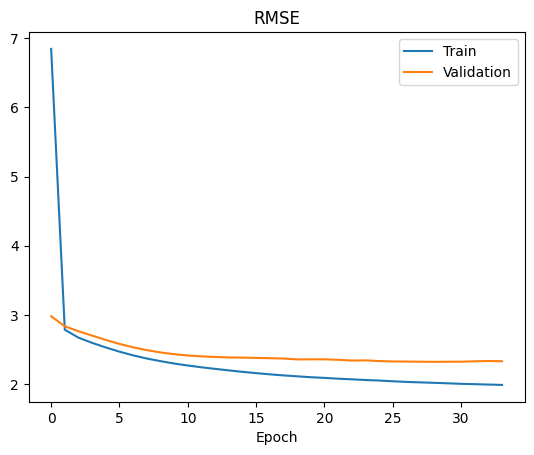

Last epoch RMSE:  2.3312750889141443


In [79]:
# Plot training and validation curves
plt.plot(np.sqrt(base_history.history['loss']), label='Train')
plt.plot(np.sqrt(base_history.history['val_loss']), label='Validation')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('Last epoch RMSE: ', np.sqrt(base_history.history['val_loss'][-1]).item())

# Testing a 'Deep Narrow' Neural Net
Instead of two hidden layers of 20 and 10 nodes, respectively, which is a "wide shallow" model, we will test a neural net with five hidden layers of six nodes each.
This retains the same total number of nodes, but creates a deeper, narrower neural net.

In [77]:
# Set random seeds for reproducibility
np.random.seed(4)
tf.random.set_seed(4)

# Define the neural net model
dn_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_arr.shape[1], X_train_arr.shape[2])),  # Reference training data arrays for mask vector, feature vector
    keras.layers.Flatten(),  # Convert to single vector for training
    keras.layers.Dense(6, activation='relu'),  # Default activation function is ReLU
    keras.layers.Dense(6, activation='relu'),  # Default activation function is ReLU
    keras.layers.Dense(6, activation='relu'),  # Default activation function is ReLU
    keras.layers.Dense(6, activation='relu'),  # Default activation function is ReLU
    keras.layers.Dense(6, activation='relu'),  # Default activation function is ReLU
    keras.layers.Dense(1)  # Regression task, single output node, default to linear activation
])

# Compile model using ADAM adaptive learning rate and MSE as loss metric
dn_model.compile(optimizer='adam', loss='mean_squared_error')

# Define an early stopping callback
# Wait 5 epochs before stopping, restore best weight values after stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
epochs = 100  # Shouldn't even need 100, likely that early stopping will fire before 100 epochs
batch_size = 32  # Standard batch size
dn_history = dn_model.fit(X_train_arr, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])

# Evaluate model on test set
y_pred = dn_model.predict(X_test_arr)  # Make predictions
r2 = r2_score(y_test, y_pred)  # Calculate R^2
rmse = root_mean_squared_error(y_test, y_pred)  # Calculate RMSE

# Print results
print(f'Test R^2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 176.4412 - val_loss: 11.0434
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5454 - val_loss: 8.5433
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6262 - val_loss: 8.0805
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1911 - val_loss: 7.7622
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8753 - val_loss: 7.5117
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6174 - val_loss: 7.2731
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3798 - val_loss: 7.0583
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1786 - val_loss: 6.8671
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9922 - val_loss: 6.6775
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8167 - val_loss: 6.5038
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6566 - val_loss: 6.3462
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

**NOTE:** The 'base' wide-shallow and deep-narrow architectures produce almost identical results. The training curves are both smooth and overfitting is present, but not drastic. The early stopping constraint fired earlier when training the wide-shallow model.

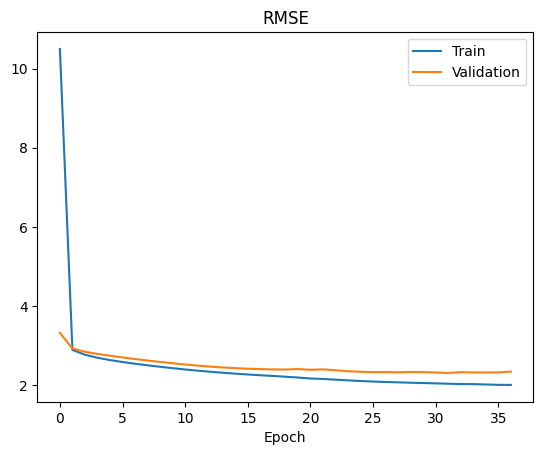

Last epoch RMSE:  2.338554116083551


In [78]:
# Plot training and validation curves
plt.plot(np.sqrt(dn_history.history['loss']), label='Train')
plt.plot(np.sqrt(dn_history.history['val_loss']), label='Validation')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('Last epoch RMSE: ', np.sqrt(dn_history.history['val_loss'][-1]).item())

# Building a Tuned Neural Net with New Hyperparameter Values

In [109]:
'''
Attempting to optimize the Neural Net using hyperparameter values:
Hidden layers: 1
Number of nodes: 30
Activation function: tanh
Dropout rate: 0.1
'''

# Define the model architecture
tuned_ws = keras.Sequential([
    keras.layers.Input(shape=(X_train_arr.shape[1], X_train_arr.shape[2])),
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation='tanh'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

# Compile the model
tuned_ws.compile(optimizer='adam', loss='mean_squared_error')

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
epochs = 100
batch_size = 32
tuned_ws_history = tuned_ws.fit(X_train_arr, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on the test set
y_pred = tuned_ws.predict(X_test_arr)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'Test R^2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 89.7676 - val_loss: 41.0501
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.9335 - val_loss: 24.1983
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.8761 - val_loss: 15.1780
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.2242 - val_loss: 10.9614
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.3947 - val_loss: 9.2415
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1757 - val_loss: 8.6170
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6041 - val_loss: 8.4265
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4325 - val_loss: 8.3703
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5700 - val_loss: 8.3541
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0260 - val_loss: 8.3503
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4293 - val_loss: 8.3524
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

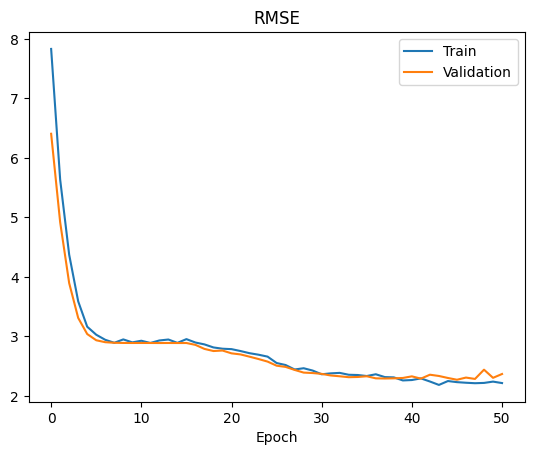

In [110]:
plt.plot(np.sqrt(tuned_ws_history.history['loss']), label='Train')
plt.plot(np.sqrt(tuned_ws_history.history['val_loss']), label='Validation')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
'''
Attempting to optimize the Neural Net using hyperparameter values:
Hidden layers: 5
Number of nodes: 12
Activation function: tanh
Dropout rate: 0.1
'''

# Define the model architecture
tuned_dn = keras.Sequential([
    keras.layers.Input(shape=(X_train_arr.shape[1], X_train_arr.shape[2])),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

# Compile the model
tuned_dn.compile(optimizer='adam', loss='mean_squared_error')

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
epochs = 100
batch_size = 32
tuned_dn_history = tuned_dn.fit(X_train_arr, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on the test set
y_pred = tuned_dn.predict(X_test_arr)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'Test R^2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 190.8828 - val_loss: 157.4189
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151.7048 - val_loss: 135.7999
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130.6238 - val_loss: 118.6925
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.4850 - val_loss: 104.2149
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102.8826 - val_loss: 92.9206
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91.8607 - val_loss: 83.4265
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81.4070 - val_loss: 75.1327
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.7129 - val_loss: 67.7880
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.5877 - val_loss: 61.1519
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.1433 - val_loss: 55.2176
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.3394 - val_loss: 49.8150
Epoch 12/100
71/71 ━━━━━━━━━━━━━

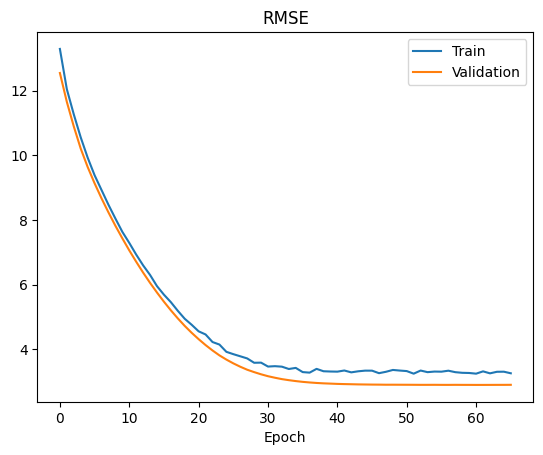

In [15]:
plt.plot(np.sqrt(tuned_dn_history.history['loss']), label='Train')
plt.plot(np.sqrt(tuned_dn_history.history['val_loss']), label='Validation')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()